<table style="border:1px solid black;border-collapse:collapse;" align="left">
  <td style="border:1px solid red;">
    <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_gensim_word2vec.ipynb">Run this notebook in Google Colab</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://github.com/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_gensim_word2vec.ipynb">View source on GitHub</a>
  </td>
  <td style="border:1px solid red;">
    <a target="_blank" href="https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92">View Zhi Li's Gensim Word2Vec tutorial on `Towards Data Science`</a>
  </td>
  <td style="border:1px solid red;">
    <a href="https://github.com/zhlli1/Genism-word2vec/blob/master/Genism%20Word2Vec%20Tutorial.ipynb">Download Zhi Li's Gensim Word2Vec tutorial notebook from Github</a>
  </td>
</table>

# Word2Vec on Windows Eventlogs
This notebook is part of a project that uses Word2Vec for anomaly detection in Windows 10 event logs.<br>
It uses a dataset which consists of all events derived from the System event log from my own PC.<br>
The data was read using Powershell and Get-WinEvent. You can find the Powershell script and the python script for parsing in my github repository.<br>
This version uses the Gensim implementation of Word2Vec, <a target="_blank" href="https://colab.research.google.com/github/Grrtzm/word2vec/blob/main/windows_eventlog_anomaly_detection_with_tensorflow_word2vec.ipynb">this version uses a Tensorflow implementation of Word2Vec</a>.

## Setup

In [1]:
# We need Gensim version >= 4.0.0 (Dec 30, 2021: v4.1.2), Colab normally uses version 3.6.0 which is not compatible
!pip install -q --upgrade gensim
import gensim

In [2]:
from os.path import exists as file_exists
if file_exists('System-Events-custom.csv') == False:
    # !pip install gdown      # uncomment if gdown is missing
    import gdown
    url = 'https://drive.google.com/uc?id=1Kt1FsUwVVTRkpxt7urykgOgDbeOpYRVn'
    output = 'System-Events-custom.csv'
    gdown.download(url, output, quiet=True)

In [3]:
import pandas as pd
import string
from datetime import datetime # For DateTime -> date operations
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Word2Vec hyperparameters:
# num_ns: Set the number of negative samples per positive context.
# num_ns: between [5, 20] is shown to work best for smaller datasets, while num_ns between [2,5] suffices for larger datasets.
num_ns = 2 # was 5
window_size = 5
embedding_dim = 20 #  20 seems to be sufficient, 128 is the default value from the tutorial   # Dimension of the dense embedding.
vocab_size = 20000 # inital size of the vocabulary. We will resize it later before defining the model.
sequence_length = 40 # Number of words in a sentence.
epochs = 600 # Number of training epochs for Word2Vec, 60 is sufficient, more than 600 doesn't improve quality
SEED = 42
use_trained_model = False

df = pd.read_csv('System-Events-custom.csv', parse_dates=["TimeCreated"]) 
df.head()

,TimeCreated,EventRecordID,EventID,Level,Provider,Message
0,2021-12-02 20:05:22.768441+00:00,37593,System_1014,Warning,Microsoft-Windows-DNS-Client,Name resolution for the name config.teams.micr...
1,2021-12-02 20:05:22.255612+00:00,37592,System_32,Information,e1dexpress,NaN
2,2021-12-02 20:05:19.153883+00:00,37591,System_6062,Warning,Netwtw08,6062 - Lso was triggered
3,2021-12-02 20:05:18.362357+00:00,37590,System_27,Warning,e1dexpress,NaN
4,2021-12-02 20:05:18.278408+00:00,37589,System_32,Information,e1dexpress,NaN


## Create Event "word" from multiple columns
This creates a new column containing the words Word2Vec will be trained on.

In [4]:
import string
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
transtab = str.maketrans(dict.fromkeys(punct, ''))

# Define a function to remove spaces
# Source: https://iqcode.com/code/python/pandas-series-remove-punctuation
# and https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
def remove_spaces(text):
    for punctuation in string.punctuation:
        text = text.replace(' ', '')
    return text

# Create a new column. Concatenate the columns, remove unwanted characters and convert to lowercase
df['Event'] = df['EventID'].map(str) + df['Level'].map(str) + df['Provider'].apply(remove_spaces).map(str)
df['Event'] = '|'.join(df['Event'].tolist()).translate(transtab).split('|') # remove all other unwanted characters
df['Event'] = df['Event'].str.lower()

# Delete the redundant columns
df = df.drop(['EventID','Level','Provider'], axis=1)

# Change order of columns by name, so we can display it orderly
df = df[['TimeCreated', 'EventRecordID', 'Event', 'Message']]

# Show a preview
df.head(8)

,TimeCreated,EventRecordID,Event,Message
0,2021-12-02 20:05:22.768441+00:00,37593,system1014warningmicrosoftwindowsdnsclient,Name resolution for the name config.teams.micr...
1,2021-12-02 20:05:22.255612+00:00,37592,system32informatione1dexpress,NaN
2,2021-12-02 20:05:19.153883+00:00,37591,system6062warningnetwtw08,6062 - Lso was triggered
3,2021-12-02 20:05:18.362357+00:00,37590,system27warninge1dexpress,NaN
4,2021-12-02 20:05:18.278408+00:00,37589,system32informatione1dexpress,NaN
5,2021-12-02 20:05:17.638712+00:00,37588,system1informationmicrosoftwindowspowertrouble...,The system has returned from a low power state...
6,2021-12-02 20:05:17.544184+00:00,37587,system7021informationnetwtw08,7021 - Connection telemetry fields and analysi...
7,2021-12-02 20:05:15.997321+00:00,37586,system18informationbthusb,Windows cannot store Bluetooth authentication ...


In [5]:
num_rows = len(df.axes[0])
print(f"Number of lines/events in the dataset: {num_rows}\n")

Number of lines/events in the dataset: 37593



## Create corpus from dataset

Create the text dataset "eventlist", a list containing "eventrow" lists. An "eventrow" list contains all events for that day.

In [6]:
minlength = 1e6
maxlength = 0
eventlist = []
eventrow = []
previous_date = None # datetime.now().date()
for idx, row in df.iterrows():
    date = row['TimeCreated'].date()
    eventrow.append(row['Event'])
    if date != previous_date:
        length = len(eventrow) + 1
        if length > maxlength: maxlength = length
        if length < minlength: minlength = length
        eventrow = []
        eventlist.append(eventrow)
        previous_date = date
        
print(f"Number of lines = {len(eventlist)}, shortest line = {minlength} words, longest line = {maxlength} words\n")

Number of lines = 263, shortest line = 2 words, longest line = 1011 words



## Train the Gensim word2vec model with our own custom corpus

Reference: https://radimrehurek.com/gensim/models/word2vec.html and https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4<br>
Gensim v4.0 was released on 31-3-2021

Let's try to understand a few of the hyperparameter of this model.
1. vector_size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
   <br>Because we are looking for anomalies, we even want to see words that occur only once, so we set `min_count = 0`
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training algorithm is CBOW. 
6. epochs: number of training cycles
7. hs: 0, 1   1=hierarchical softmax
8. negative: If set to 0, no negative sampling is used (usually between 5-20)
9. seed: Seed for the random number generator. 

In [7]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

losses = []

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0

    def on_epoch_end(self, model):
        epoch_loss = model.get_latest_training_loss()
        if self.epoch == 0:
            loss_now = epoch_loss
        else:
            loss_now = epoch_loss - self.loss_previous_step
            
        if ((self.epoch / 250) % 2 == 0): print(f"epoch: {self.epoch}, loss: {loss_now}")
        self.loss_previous_step = epoch_loss
        losses.append(loss_now)
        self.epoch += 1

# If you would like to test yourself, you can choose either skip-gram or CBOW model. CBOW gave me the best results.

# Skip-gram:
# model = Word2Vec(sentences=eventlist, min_count=0, vector_size=embedding_dim, workers=8, window=window_size, sg=1, epochs=epochs, seed=SEED, hs=0, negative=num_ns, shrink_windows=True, compute_loss=True, callbacks=[callback()])

# CBOW:
# model = Word2Vec(sentences=eventlist, min_count=0, vector_size=embedding_dim, workers=8, window=window_size, sg=0, epochs=epochs, seed=SEED, hs=1, negative=0, shrink_windows=True, compute_loss=True, callbacks=[callback()])

if use_trained_model == False:
    # CBOW model; sg=0, Set min_count=0 to allow 'words' (events) that only occur once. These parameters gave the best and most consistent results:
    model = Word2Vec(sentences=eventlist, min_count=0, vector_size=embedding_dim, workers=1, window=window_size, sg=0, epochs=epochs, hs=0, negative=num_ns, compute_loss=True, callbacks=[callback()])
    # The model can be stored/loaded via its save() and load() methods (fast and optimized), or stored/loaded in a format compatible with the original word2vec implementation via save_word2vec_format() and load_word2vec_format().
    model.save('word2vec.model')
else:
    model = Word2Vec.load('word2vec.model')

epoch: 0, loss: 27926.3515625
epoch: 500, loss: 9990.0


### Show training plot

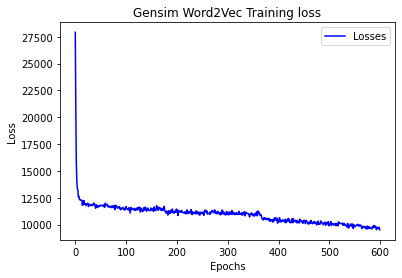

In [8]:
if use_trained_model == False:
    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    epochs=range(len(losses)) # Get number of epochs

    plt.plot(epochs, losses, 'b')
    plt.title('Gensim Word2Vec Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Losses"])
    plt.savefig("gensim_word2vec_training_loss.png", format="png")
    plt.show()

### Embedding lookup and analysis
Save the wordvectors to analyze the obtained embeddings in the Embedding Projector

In [9]:
# Store just the words + their trained embeddings.
word_vectors = model.wv
# The model can be stored/loaded via its save() and load() methods, or stored/loaded in a format compatible with the original word2vec implementation via save_word2vec_format() and load_word2vec_format().
word_vectors.save_word2vec_format("word2vec.wordvectors", fvocab="word2vec.vocab")

Run the cell below to download the `word2vec.wordvectors`.

In [10]:
try:
    from google.colab import files
    files.download('word2vec.wordvectors')
    files.download('word2vec.vocab')
except Exception:
    pass

On your PC, from the command prompt type `python -m gensim.scripts.word2vec2tensor -i word2vec.wordvectors -o .\`<br>to convert the wordvectors to the `_tensor.tsv` and `_metadata.tsv` files which can be read by the [Embedding Projector](https://projector.tensorflow.org/). 

### Just testing some Word2Vec distance/similarity functions

In [11]:
print(f"Number of words in internal Word2Vec vocabulary: {len(model.wv)}\n")
print(model.wv.get_vector('system137errorntfs', norm=True))
print()
print(model.wv.similarity('system136warningntfs','system137errorntfs'))
print()
print(model.wv.distance('system136warningntfs','system137errorntfs'))
print()
print(model.wv.distances('system137errorntfs', other_words=(["system26informationapplicationpopup","system51warningdisk"])))
print()
print(model.wv.rank_by_centrality(['system51warningdisk','system137errorntfs'], use_norm=True))
print()

Number of words in internal Word2Vec vocabulary: 191

[-1.9142601e-01 -1.1913723e-01  2.1970883e-01  3.2118848e-01
  5.0254667e-01  1.1049557e-01  1.4130351e-01 -1.1237276e-01
 -1.6775322e-01 -4.7262006e-02 -2.9707313e-01 -9.9806137e-02
 -3.0136034e-01  1.3773541e-04  5.1249910e-02 -2.7696106e-01
  5.1867221e-02 -4.2282358e-01 -5.1517049e-03 -1.4189599e-01]

0.8708573

0.12914270162582397

[0.24409819 0.66511613]

[(0.81697124, 'system51warningdisk'), (0.8169712, 'system137errorntfs')]



## Calculate `cosine_similarity` for each event
And add these as a a column to the dataset.

In [12]:
num_events = len(df.axes[0])
# add empty columns
cos_sim = []
for idx, row in df.iterrows():
    current_event = row['Event']
    if idx == 0:
        cos_sim.append(float(1))
        previous_event = current_event
    if idx > 0:
        if idx < num_events + 1:
            cs = model.wv.similarity(current_event, previous_event)
            cos_sim.append(cs)
            previous_event = current_event

df['cos_sim'] = cos_sim

# Change order of columns by name, so we can display it orderly
df = df[['TimeCreated', 'EventRecordID', 'Event', 'cos_sim', 'Message']]
df.head()

# saving the dataframe
df.to_csv('System-Events-similarity-Gensim.csv')

## Plot all anomalies
The lower the line spikes, the more unique it is.

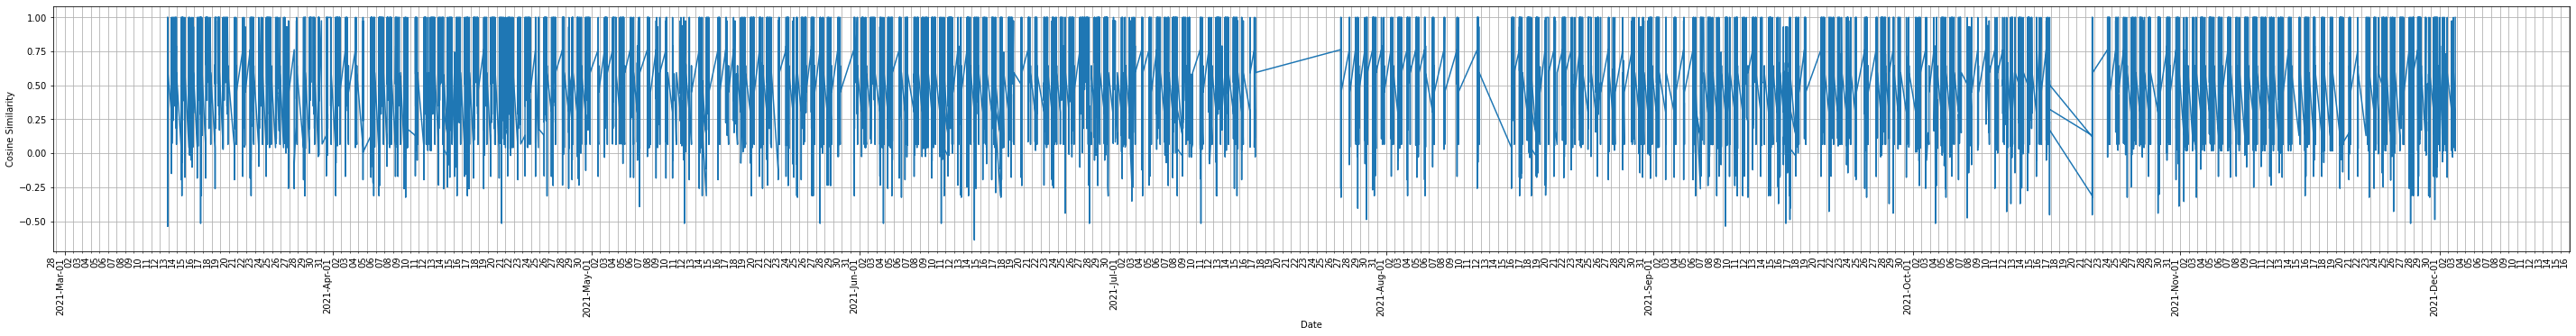

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, figsize=(50, 5))
x = df['TimeCreated']
y = df['cos_sim']
line, = ax.plot(x, y)
# Major ticks every month, minor ticks every day,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both', axis='both')
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=90, horizontalalignment='right')
for label in ax.get_xticklabels(which='minor'):
    label.set(rotation=90, horizontalalignment='right')
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.savefig("cos_sim_gensim.png", format="png")
plt.show()

## Show some statistics

In [14]:
print(df['cos_sim'].describe())

count    37593.000000
mean         0.594285
std          0.349165
min         -0.638193
25%          0.347295
50%          0.571602
75%          1.000000
max          1.000000
Name: cos_sim, dtype: float64


## Show Top 10 of all anomalies

In [15]:
# Pandas display settings
pd.set_option('display.max_columns', None) # Set it to None to display all columns in the dataframe
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth', None)

print("Top 10 of all 'anomalies':\n")
df.nsmallest(n=10, columns=['cos_sim'])

Top 10 of all 'anomalies':



,TimeCreated,EventRecordID,Event,cos_sim,Message
24039,2021-06-14 07:59:45.512246+00:00,13554,system4warningmeix64,-0.638193,The Intel(R) Management Engine Interface is being disabled.
24038,2021-06-14 07:59:45.615966+00:00,13555,system2informationmeix64,-0.617404,Intel(R) Management Engine Interface driver has started successfully.
13127,2021-09-09 07:42:08.032689+00:00,24466,system6informationmicrosoftwindowsfiltermanager,-0.536768,"File System Filter 'bindflt' (10.0, ‎2001‎-‎07‎-‎17T04:21:27.000000000Z) has successfully loaded and registered with Filter Manager."
37133,2021-03-12 21:35:01.688522+00:00,460,system6informationmicrosoftwindowsfiltermanager,-0.536768,"File System Filter 'WdFilter' (10.0, ‎2096‎-‎03‎-‎31T00:06:20.000000000Z) has successfully loaded and registered with Filter Manager."
37232,2021-03-12 21:32:08.092537+00:00,361,system6informationmicrosoftwindowsfiltermanager,-0.536768,"File System Filter 'bindflt' (10.0, ‎1986‎-‎11‎-‎02T03:57:03.000000000Z) has successfully loaded and registered with Filter Manager."
1829,2021-11-27 15:54:53.044093+00:00,35764,system10002warningmicrosoftwindowswlanautoconfig,-0.516232,WLAN Extensibility Module has stopped.\r\n\r\nModule Path: C:\WINDOWS\system32\IntelIHVRouter08.dll\r\n
9248,2021-10-03 15:15:42.250925+00:00,28345,system10002warningmicrosoftwindowswlanautoconfig,-0.516232,WLAN Extensibility Module has stopped.\r\n\r\nModule Path: C:\WINDOWS\system32\IntelIHVRouter08.dll\r\n
11689,2021-09-16 07:33:14.397578+00:00,25904,system10002warningmicrosoftwindowswlanautoconfig,-0.516232,WLAN Extensibility Module has stopped.\r\n\r\nModule Path: C:\WINDOWS\system32\IntelIHVRouter08.dll\r\n
20160,2021-07-10 13:45:33.268784+00:00,17433,system10002warningmicrosoftwindowswlanautoconfig,-0.516232,WLAN Extensibility Module has stopped.\r\n\r\nModule Path: C:\WINDOWS\system32\IntelIHVRouter08.dll\r\n
22273,2021-06-27 15:38:09.678158+00:00,15320,system10002warningmicrosoftwindowswlanautoconfig,-0.516232,WLAN Extensibility Module has stopped.\r\n\r\nModule Path: C:\WINDOWS\system32\IntelIHVRouter08.dll\r\n


As you can see above, those anomalies are probably not always what you expected. We are not interested in 'Information' events. 
<br> Now lets take a look at some more interesting events.
## Show Top 10 of 'critical' anomalies

In [16]:
dfcritical = df[df['Event'].str.contains('critical')]
print(f"Top 10 of 'critical' anomalies from a total of {len(dfcritical)} 'critical' events:\n")
dfcritical.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'critical' anomalies from a total of 14 'critical' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
570,2021-11-30 11:19:04.976339+00:00,37023,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
9440,2021-10-01 18:28:17.428702+00:00,28153,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
14500,2021-08-31 15:15:12.123075+00:00,23093,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
26725,2021-05-28 16:46:49.554694+00:00,10868,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
27941,2021-05-23 18:34:47.785323+00:00,9652,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
30925,2021-04-26 13:11:40.205236+00:00,6668,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31140,2021-04-25 12:11:55.396258+00:00,6453,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31401,2021-04-23 06:53:59.632369+00:00,6192,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31674,2021-04-21 07:02:53.221205+00:00,5919,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."
31759,2021-04-21 07:00:39.765228+00:00,5834,system41criticalmicrosoftwindowskernelpower,0.35586,"The system has rebooted without cleanly shutting down first. This error could be caused if the system stopped responding, crashed, or lost power unexpectedly."


## Show Top 10 of 'error' anomalies

In [17]:
dferror = df[df['Event'].str.contains('error')]
print(f"Top 10 of 'error' anomalies from a total of {len(dferror)} 'error' events:\n")
dferror.nsmallest(n=10, columns=['cos_sim'])

Top 10 of 'error' anomalies from a total of 1054 'error' events:



,TimeCreated,EventRecordID,Event,cos_sim,Message
14430,2021-08-31 15:15:40.517659+00:00,23163,system1001errormicrosoftwindowswersystemerrorreporting,-0.184838,"The computer has rebooted from a bugcheck. The bugcheck was: 0x00000109 (0xa3a004e23def3663, 0x0000000000000000, 0x1049d96c353a27eb, 0x0000000000000101). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: 188d660c-6628-4f32-be56-781624281ae2."
26665,2021-05-28 16:47:09.837706+00:00,10928,system1001errormicrosoftwindowswersystemerrorreporting,-0.184838,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000001a (0x0000000000061948, 0x0000000001008000, 0x0000000000000001, 0x0000000001008000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: 983ac434-d271-4a0e-9de0-6eaf64583e30."
27873,2021-05-23 18:35:15.357416+00:00,9720,system1001errormicrosoftwindowswersystemerrorreporting,-0.184838,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000001a (0x0000000000061948, 0x0000000001008000, 0x0000000000000001, 0x0000000001008000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: d8b55560-809f-4550-aba8-25b45a3106aa."
30868,2021-04-26 13:12:01.443939+00:00,6725,system1001errormicrosoftwindowswersystemerrorreporting,-0.184838,"The computer has rebooted from a bugcheck. The bugcheck was: 0x0000003b (0x00000000c0000005, 0xfffff8041d896d93, 0xfffff601f75b6af0, 0x0000000000000000). A dump was saved in: C:\WINDOWS\MEMORY.DMP. Report Id: b380d75b-57ae-4626-a341-c543ad9e6c79."
29477,2021-05-09 14:49:37.884761+00:00,8116,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32096,2021-04-18 12:13:42.183632+00:00,5497,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32221,2021-04-17 07:38:17.117611+00:00,5372,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
32239,2021-04-16 19:21:22.771181+00:00,5354,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
33633,2021-04-09 06:54:45.396437+00:00,3960,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
35621,2021-03-27 13:29:05.829182+00:00,1972,system10010errormicrosoftwindowsdistributedcom,-0.182824,The server Microsoft.SkypeApp_15.68.96.0_x86__kzf8qxf38zg5c!App.AppXtwmqn4em5r5dpafgj4t4yyxgjfe0hr50.mca did not register with DCOM within the required timeout.
